In [480]:
import numpy as np
import open3d as o3d

# Define sphere properties
center = [0, 0, 0]  # Center of the sphere
radius = 10  # Radius of the sphere
num_points = 100000  # Number of points in the sphere point cloud

# Generate points on the surface of the sphere
u = np.random.rand(num_points)
v = np.random.rand(num_points)
theta = 2 * np.pi * u
phi = np.arccos(2 * v - 1)
x = center[0] + radius * np.sin(phi) * np.cos(theta)
y = center[1] + radius * np.sin(phi) * np.sin(theta)
z = center[2] + radius * np.cos(phi)

# Create PointCloud object
pcd = o3d.geometry.PointCloud()

# Add points to PointCloud object
pcd.points = o3d.utility.Vector3dVector(np.column_stack((x, y, z)))

# Visualize point cloud in Open3D
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [1]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Polygon, Point


In [2]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
    
        header = laspy.LasHeader(point_format=input_las.header.point_format, version=input_las.header.version)
        header.scales = np.array([0.001, 0.001, 0.001])
        header.x_offset=input_las.header.offsets[0]
        header.y_offset=input_las.header.offsets[1]
        header.z_offset=input_las.header.offsets[2]

        classified_points = laspy.LasData(header)
        

        epsg=2960
        crs = pyproj.CRS.from_epsg(epsg)  # example: WGS84
        classified_points.header.add_crs(crs)

        #classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

        classified_points.points = input_las.points[input_las.classification == classification]

        classified_points.header.offsets = input_las.header.offsets

        
        d["classification_{}".format(str(classification))] = classified_points

    print(d)
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df


def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=1000, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")


def create_laspy_from_dataframe(input_las,combined_df):
    #classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

    #Create a header for the new .Las file
    # Header class properties (https://laspy.readthedocs.io/en/latest/api/laspy.header.html)
    header = laspy.LasHeader(point_format=input_las.header.point_format, version=input_las.header.version)
    header.scales = np.array([0.001, 0.001, 0.001])
    header.x_offset=input_las.header.offsets[0]
    header.y_offset=input_las.header.offsets[1]
    header.z_offset=input_las.header.offsets[2]

    classified_points = laspy.LasData(header)

    crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
    #Apply the add_crs function to add a crs to our header.
    classified_points.header.add_crs(crs)
    #Select the offset from the input las data.

    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]
    classified_points.return_number = combined_df["return_number"]
    classified_points.number_of_returns = combined_df["number_of_returns"]
    classified_points.synthetic = combined_df["synthetic"]
    classified_points.key_point = combined_df["key_point"]
    classified_points.withheld = combined_df["withheld"]
    classified_points.scanner_channel = combined_df["scanner_channel"]
    classified_points.scan_direction_flag = combined_df["scan_direction_flag"]
    classified_points.user_data = combined_df["user_data"]
    classified_points.withheld = combined_df["withheld"]
    classified_points.scan_angle = combined_df["scan_angle"]
    classified_points.point_source_id = combined_df["point_source_id"]
    classified_points.gps_time = combined_df["gps_time"]


    classified_points.header.offsets = input_las.header.offsets

    
    return classified_points

    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [3]:
def filter_point_cloud(input_las, quarter_size=10):
    # Load the LAS file
    las_clean_percentile = input_las
    header = laspy.LasHeader(point_format=las_clean_percentile.header.point_format, version=las_clean_percentile.header.version)
    
    crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
    las_clean_percentile.header.add_crs(crs=crs)

    header.scales = np.array([0.001, 0.001, 0.001])
    header.x_offset=input_las.header.offsets[0]
    header.y_offset=input_las.header.offsets[1]
    header.z_offset=input_las.header.offsets[2]
    

    las_clean_percentile.header.offsets = input_las.header.offsets
    #las_clean_percentile.header.y_offset = 0

    # Compute the x, y, and z quartiles
    x_quarter = np.percentile(las_clean_percentile.X, [25, 50, 75])
    print(x_quarter)
    y_quarter = np.percentile(las_clean_percentile.Y, [25, 50, 75])
    print(y_quarter)
    z_quarter = np.percentile(las_clean_percentile.Z, [25, 50, 75])
    print(z_quarter)


    # Filter out points outside the inner quartile range
    x_mask = np.logical_and(las_clean_percentile.X >= x_quarter[0] - quarter_size, las_clean_percentile.X <= x_quarter[2] + quarter_size)
    y_mask = np.logical_and(las_clean_percentile.Y >= y_quarter[0] - quarter_size, las_clean_percentile.Y <= y_quarter[2] + quarter_size)
    z_mask = np.logical_and(las_clean_percentile.Z >= z_quarter[0] - quarter_size, las_clean_percentile.Z <= z_quarter[2] + quarter_size)


    mask = np.logical_and(np.logical_and(x_mask, y_mask), z_mask)
    las_clean_percentile = las_clean_percentile[mask]
    #las_clean_percentile = las[mask]

    return las_clean_percentile


def classified_scaled_numpy(las,df,scaled = True):
    classifications = get_list_classifications(input_las=las)
    class_selections = get_selected_classes(classifications = classifications,input_las=las)
    # Form a pandas dataframe from user-selected classifications
    combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)

    ##Create laspy points from the pandas dataframe of selected user classifications
    classified_points = create_laspy_from_dataframe(input_las=las,combined_df=combined_df)

    ###                                 ###
    ###DATA CONVERSION FOR VISUALIZATION###
    ###             #                   ###
    # Convert classified_points (laspy data) or combined_df (pandas data) to numpy data for visualization
    #   with the pptk library. 
    #Convert from laspy to numpy scaled
    if scaled == True:
        classified_points_numpy_scaled_laspy = get_numpy_points_from_laspy_scaled(classified_points=classified_points)
        return classified_points_numpy_scaled_laspy
    else:
        #Convert from laspy to numpy unscaled
        classified_points_numpy_unscaled_laspy = get_numpy_points_from_laspy_unscaled(classified_points=classified_points)
        return classified_points_numpy_unscaled_laspy


#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        shift = 0.0001
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        coord2 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.min(),df.Y.min(),df.Z.min()])
        coord3 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.min(),df.Y.min(),df.Z.max()])
        coord4 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.min(),df.Y.max(),df.Z.max()])
        coord5 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.min(),df.Y.max(),df.Z.min()])
        coord6 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.max(),df.Y.max(),df.Z.max()])
        coord7 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.max(),df.Y.min(),df.Z.min()])
        coord8 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.max(),df.Y.min(),df.Z.max()])
        coord9 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=10000/2, origin=[df.X.max(),df.Y.max(),df.Z.min()])

        bbox1 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()+(shift*df.X.mean()) ,df.Y.mean()+(shift*df.Y.mean()),df.Z.mean()+(shift*df.Z.mean())])
        bbox2 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()+(shift*df.X.mean()) ,df.Y.mean()+(shift*df.Y.mean()),df.Z.mean()-(shift*df.Z.mean())])
        bbox3 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()+(shift*df.X.mean()) ,df.Y.mean()-(shift*df.Y.mean()),df.Z.mean()+(shift*df.Z.mean())])
        bbox4 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()+(shift*df.X.mean()) ,df.Y.mean()-(shift*df.Y.mean()),df.Z.mean()-(shift*df.Z.mean())]) 

        bbox5 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()-(shift*df.X.mean()) ,df.Y.mean()+(shift*df.Y.mean()),df.Z.mean()+(shift*df.Z.mean())])
        bbox6 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()-(shift*df.X.mean()) ,df.Y.mean()+(shift*df.Y.mean()),df.Z.mean()-(shift*df.Z.mean())])
        bbox7 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()-(shift*df.X.mean()) ,df.Y.mean()-(shift*df.Y.mean()),df.Z.mean()+(shift*df.Z.mean())])
        bbox8 = o3d.geometry.TriangleMesh().create_coordinate_frame(size=20000, origin=[df.X.mean()-(shift*df.X.mean()) ,df.Y.mean()-(shift*df.Y.mean()),df.Z.mean()-(shift*df.Z.mean())])     
        

          
        o3d.visualization.draw_geometries([coord,coord2,coord3,coord4,coord5,coord6,coord7,coord8,coord9,bbox1,bbox2,bbox3,
        bbox4,bbox5,bbox6,bbox7,bbox8,geom])

        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")



In [4]:
input_las = load_laspy('Tile65_Original_Clean_Macro.las')
df = convert_laspy_pandas(input_las=input_las)
filtered_las = filter_point_cloud(input_las, quarter_size=1000)
df_filtered = convert_laspy_pandas(input_las=filtered_las)


[2.90962504e+08 2.91001760e+08 2.91036117e+08]
[-1.86921073e+08 -1.86880901e+08 -1.86841998e+08]
[-6246. -1162.  -367.]


##  Select to work with either filtered or unfiltered values.

In [5]:
#classified_points_numpy_unscaled_laspy = classified_scaled_numpy(input_las, df, scaled =False)
filtered_classified_unscaled = classified_scaled_numpy(filtered_las, df_filtered, scaled =False)

Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
The entire dataset has been selected
All classes have been added to the dataframe.


## Visualization

In [6]:
#visualize_las(classified_points=classified_points_numpy_unscaled_laspy,df=df)
visualize_las(classified_points=filtered_classified_unscaled,df=df_filtered)

entered df
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


### Create a python dictionary with all separate classifications

In [7]:
filtered_classifications = get_classifications_laspy(input_las = filtered_las)

The classifications contained in this .las dataset are: 
[0, 7, 9, 18, 40, 41, 42, 80]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 0
Saving classification number: 7
Saving classification number: 9
Saving classification number: 18
Saving classification number: 40
Saving classification number: 41
Saving classification number: 42
Saving classification number: 80
{'original_dataset': <LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 312097 points, 1 vlrs)>, 'classification_0': <LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 81747 points, 1 vlrs)>, 'classification_7': <LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 556 points, 1 vlrs)>, 'classification_9': <LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 4698 points, 1 vlrs)>, 'classification_18': <LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 320 point

### Bathymetry classification - laspy and pandas object

In [8]:
bathymetry_filtered = filtered_classifications["classification_40"]
#bathymetry_filtered
bathymetry_filtered_df = df_filtered[df_filtered["classification"] == 40]
#bathymetry_filtered_df

In [9]:
bathymetry_filtered_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
659,290999431,-186842234,-6559,290999.431,4813157.766,-6.559,22883,40,1,2,0,0,0,0,0,1,2,-2341,2610,135244.323339
660,290998253,-186842142,-6500,290998.253,4813157.858,-6.500,18110,40,1,1,0,0,0,0,0,1,2,-2317,2610,135244.323368
661,290997047,-186842045,-6468,290997.047,4813157.955,-6.468,19755,40,1,1,0,0,0,0,0,1,2,-2293,2610,135244.323397
663,290995854,-186841942,-6445,290995.854,4813158.058,-6.445,16134,40,2,4,0,0,0,0,0,1,2,-2268,2610,135244.323427
664,290994679,-186841835,-6434,290994.679,4813158.165,-6.434,23140,40,2,2,0,0,0,0,0,1,2,-2244,2610,135244.323456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310669,291001947,-186919980,-7219,291001.947,4813080.020,-7.219,16228,40,1,1,0,0,0,0,0,0,4,3268,2812,135838.302861
310771,291001050,-186921033,-7207,291001.050,4813078.967,-7.207,16467,40,2,2,0,0,0,0,0,0,4,3272,2812,135838.312171
310827,291000292,-186922037,-7089,291000.292,4813077.963,-7.089,13893,40,2,2,0,0,0,0,0,0,4,3276,2812,135838.321485
310829,291000815,-186921700,-7156,291000.815,4813078.300,-7.156,15419,40,2,2,0,0,0,0,0,0,4,3270,2812,135838.321499


In [10]:
def get_centroid(input_las):
    return np.array([np.array(input_las.x).mean(), np.array(input_las.y).mean(), np.array(input_las.z).mean()])


def centroid_area_to_polygon(centroid,length=10,width=20,x_shift=0,y_shift=0):
    from shapely.geometry import Polygon

    rect_coords = [(centroid[0] - length + x_shift, centroid[1] - width + y_shift),
                (centroid[0] + length + x_shift, centroid[1] - width + y_shift),
                (centroid[0] + length + x_shift, centroid[1] + width + y_shift),
                (centroid[0] - length + x_shift, centroid[1] + width + y_shift)]

    polygon = Polygon(rect_coords)

    return polygon

def points_in_centroid_area(input_las,centroid,length = 10, width = 20, height = 5 ,x_shift=0,y_shift=0,z_shift=0):

    xmin = centroid[0] - length + x_shift
    xmax = centroid[0] + length + x_shift
    ymin = centroid[1] - width + y_shift
    ymax = centroid[1] + width + y_shift
    zmin = centroid[2] - height + z_shift
    zmax = centroid[2] + height + z_shift

    selection = ((np.array(input_las.x) >= xmin) & (np.array(input_las.x) <= xmax) &
        (np.array(input_las.y)>= ymin) & (np.array(input_las.y) <= ymax) &
        (np.array(input_las.z) >= zmin) & (np.array(input_las.z) <= zmax))

    return selection


def subset_point_cloud(input_las,centroid,las_filename,shp_file_name,length = 10, width = 20, height = 5, x_shift=0, y_shift=0, z_shift=0, polygon_flag=False,las_write=False,shp_file_write=False):
    # Load the LAS file
    las_subset = input_las
    header = laspy.LasHeader(point_format=las_subset.header.point_format, version=las_subset.header.version)
    
    crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
    las_subset.header.add_crs(crs=crs)

    header.scales = input_las.header.scales

    las_subset.header.offsets = input_las.header.offsets

    polygon = centroid_area_to_polygon(centroid=centroid,length=length,width=width,x_shift=x_shift, y_shift=y_shift)

    selection = points_in_centroid_area(input_las=las_subset,centroid=centroid,length = length, width = width, height = height,x_shift=x_shift, y_shift=y_shift, z_shift=z_shift)
    las_subset = las_subset[selection]

    if polygon_flag == True:
        if las_write == True: 
            las_subset.write("{}.las".format(las_filename))
            if shp_file_write == True:
                gdf = gpd.GeoDataFrame(geometry=[polygon])
                gdf.crs = {'init': 'epsg:2960'}
                # Save the GeoDataFrame as a shapefile
                gdf.to_file('{}.shp'.format(shp_file_name), driver='ESRI Shapefile')

                return las_subset, polygon
            else:
                return las_subset, polygon
        else:
            return las_subset, polygon

    else:
        if las_write == True: 
            las_subset.write("{}.las".format(las_filename))
            return las_subset
        else:
            return las_subset



### Create bathymetry test and training data

In [11]:
bathymetry_centroid = get_centroid(bathymetry_filtered)

bathymetry_training_data,polygon_bathymetry_training_data = subset_point_cloud(input_las = bathymetry_filtered,centroid=bathymetry_centroid,las_filename="bathymetry_training_data",shp_file_name="polygon_bathymetry_training_data",length = 30, width = 30, height = 5, x_shift=0, y_shift=-15, z_shift=0, polygon_flag=True,las_write=True,shp_file_write=True)
bathymetry_test_data, polygon_bathymetry_test_data = subset_point_cloud(input_las = bathymetry_filtered,centroid=bathymetry_centroid,las_filename="bathymetry_test_data",shp_file_name="polygon_bathymetry_test_data",length = 30, width = 20, height = 5, x_shift=0, y_shift=+40, z_shift=0, polygon_flag=True,las_write=True,shp_file_write=True)
#bathymetry_training_data


/Users/juancreyes/opt/anaconda3/envs/py38lidar/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/juancreyes/opt/anaconda3/envs/py38lidar/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
print(bathymetry_centroid)
print(bathymetry_training_data)
print(polygon_bathymetry_training_data)

[ 2.90991898e+05  4.81312009e+06 -6.38615531e+00]
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 50280 points, 1 vlrs)>
POLYGON ((290961.8983831756 4813075.092290039, 291021.8983831756 4813075.092290039, 291021.8983831756 4813135.092290039, 290961.8983831756 4813135.092290039, 290961.8983831756 4813075.092290039))


In [13]:
print(bathymetry_centroid)
print(bathymetry_test_data)
print(polygon_bathymetry_test_data)
print(bathymetry_filtered.y)
print(bathymetry_training_data.y)

[ 2.90991898e+05  4.81312009e+06 -6.38615531e+00]
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 18137 points, 1 vlrs)>
POLYGON ((290961.8983831756 4813140.092290039, 291021.8983831756 4813140.092290039, 291021.8983831756 4813180.092290039, 290961.8983831756 4813180.092290039, 290961.8983831756 4813140.092290039))
<ScaledArrayView([4813157.766 4813157.858 4813157.955 ... 4813077.963 4813078.3
 4813078.641])>
<ScaledArrayView([4813134.819 4813134.83  4813134.861 ... 4813077.963 4813078.3
 4813078.641])>


### Plotting bathymetry training data

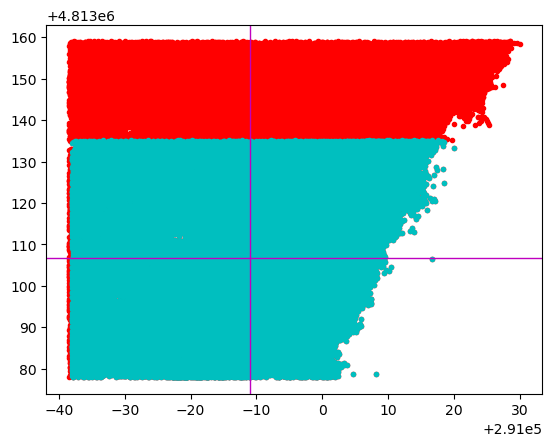

In [14]:
plt.plot(bathymetry_filtered.x,bathymetry_filtered.y,"r.",)
plt.plot(np.array(bathymetry_filtered.x).mean(),np.array(bathymetry_filtered.y).mean(),"b+",markersize=12)
plt.plot(np.array(bathymetry_filtered.x).mean()+1,np.array(bathymetry_filtered.y).mean()+1,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()-1,np.array(bathymetry_filtered.y).mean()+1,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()+1,np.array(bathymetry_filtered.y).mean()-1,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()-1,np.array(bathymetry_filtered.y).mean()-1,"b.",)

plt.plot(bathymetry_training_data.x,bathymetry_training_data.y,"c.")
plt.plot(np.array(bathymetry_training_data.x).mean(),np.array(bathymetry_training_data.y).mean(),"m+",markersize=1000)

### Plotting bathymetric test data

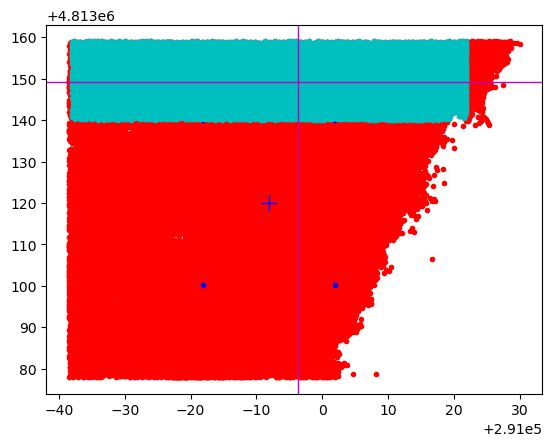

In [15]:
plt.plot(bathymetry_filtered.x,bathymetry_filtered.y,"r.",)
plt.plot(np.array(bathymetry_filtered.x).mean(),np.array(bathymetry_filtered.y).mean(),"b+",markersize=12)
plt.plot(np.array(bathymetry_filtered.x).mean()+10,np.array(bathymetry_filtered.y).mean()+20,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()-10,np.array(bathymetry_filtered.y).mean()+20,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()+10,np.array(bathymetry_filtered.y).mean()-20,"b.",)
plt.plot(np.array(bathymetry_filtered.x).mean()-10,np.array(bathymetry_filtered.y).mean()-20,"b.",)

plt.plot(bathymetry_test_data.x,bathymetry_test_data.y,"c.")
plt.plot(np.array(bathymetry_test_data.x).mean(),np.array(bathymetry_test_data.y).mean(),"m+",markersize=1000)



# Water Surface

### Water surface classification - laspy and pandas object
Get class selections for 41 and 42 to join them as one class, create a combined df, then create a laspy object

In [16]:
def get_classifications_df_laspy(input_las,df):
    classifications = get_list_classifications(input_las=input_las)
    class_selections = get_selected_classes(classifications = classifications,input_las=input_las)
    combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)
    laspy_combined = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

    return combined_df,laspy_combined

In [17]:
water_surface_filtered = filtered_classifications["classification_41"]
water_surface_filtered_df = df_filtered[df_filtered["classification"] == 41]

water_surface_derived_filtered = filtered_classifications["classification_42"]
water_surface_derived_filtered_df = df_filtered[df_filtered["classification"] == 42]

#select numbers 41 and 42 for synthetic surface and classified surface
filtered_water_surface_combined_df,filtered_water_surface_combined =  get_classifications_df_laspy(input_las = filtered_las ,df = df_filtered)



Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
Class 41 added to dataframe.
Available classifications: [0, 7, 9, 18, 40, 42, 80]
Class 42 added to dataframe.
Classifications have been selected.


### Create centroid and create training and test data .las files
### Additionally generate polygon regions.

In [18]:
filtered_water_surface_combined_centroid = get_centroid(filtered_water_surface_combined)

filtered_water_surface_combined_training_data,polygon_filtered_water_surface_combined = subset_point_cloud(input_las = filtered_water_surface_combined,centroid=filtered_water_surface_combined_centroid,las_filename="filtered_water_surface_combined_training_data",shp_file_name="polygon_filtered_water_surface_combined_training_data",length = 30, width = 60, height = 5, x_shift=-15, y_shift=15, z_shift=0, polygon_flag=True,las_write=True,shp_file_write=True)
filtered_water_surface_test_data, polygon_filtered_water_surface_test_data = subset_point_cloud(input_las = filtered_water_surface_combined,centroid=filtered_water_surface_combined_centroid,las_filename="filtered_water_surface_test_data",shp_file_name="polygon_filtered_water_surface_combined_test_data",length = 30, width = 60, height = 5, x_shift=50, y_shift=15, z_shift=0, polygon_flag=True,las_write=True,shp_file_write=True)

/Users/juancreyes/opt/anaconda3/envs/py38lidar/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/juancreyes/opt/anaconda3/envs/py38lidar/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Plot training data

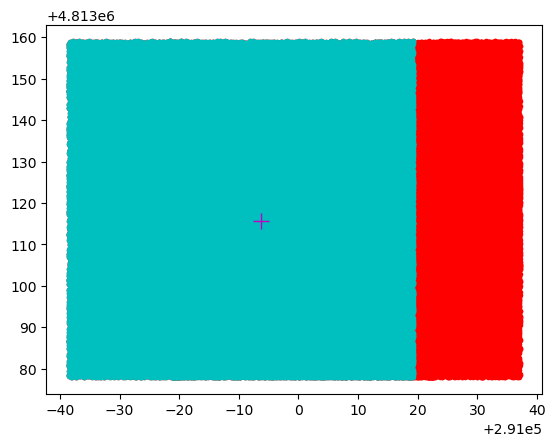

In [19]:
plt.plot(filtered_water_surface_combined.x,filtered_water_surface_combined.y,"r.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean(),np.array(filtered_water_surface_combined.y).mean(),"b+",markersize=12)
plt.plot(np.array(filtered_water_surface_combined.x).mean()+10,np.array(filtered_water_surface_combined.y).mean()+10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()-10,np.array(filtered_water_surface_combined.y).mean()+10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()+10,np.array(filtered_water_surface_combined.y).mean()-10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()-10,np.array(filtered_water_surface_combined.y).mean()-10,"b.",)

plt.plot(filtered_water_surface_combined_training_data.x,filtered_water_surface_combined_training_data.y,"c.")
plt.plot(np.array(filtered_water_surface_combined_training_data.x).mean(),np.array(filtered_water_surface_combined_training_data.y).mean(),"m+",markersize=12)



### Plot test data

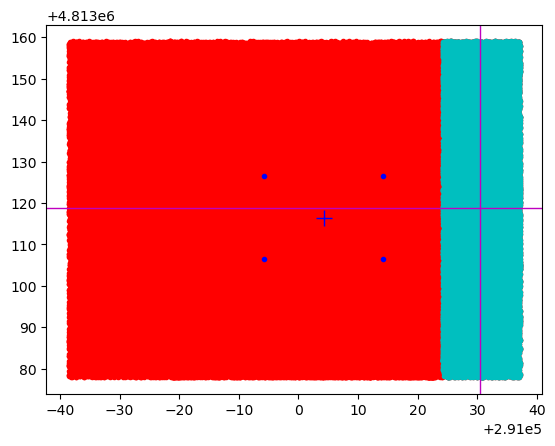

In [20]:
plt.plot(filtered_water_surface_combined.x,filtered_water_surface_combined.y,"r.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean(),np.array(filtered_water_surface_combined.y).mean(),"b+",markersize=12)
plt.plot(np.array(filtered_water_surface_combined.x).mean()+10,np.array(filtered_water_surface_combined.y).mean()+10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()-10,np.array(filtered_water_surface_combined.y).mean()+10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()+10,np.array(filtered_water_surface_combined.y).mean()-10,"b.",)
plt.plot(np.array(filtered_water_surface_combined.x).mean()-10,np.array(filtered_water_surface_combined.y).mean()-10,"b.",)

plt.plot(filtered_water_surface_test_data.x,filtered_water_surface_test_data.y,"c.")
plt.plot(np.array(filtered_water_surface_test_data.x).mean(),np.array(filtered_water_surface_test_data.y).mean(),"m+",markersize=1000)



# Creating reference height for water level

In [21]:
filtered_water_surface_combined

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 138392 points, 1 vlrs)>

####  Water surface vertical distribution

<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

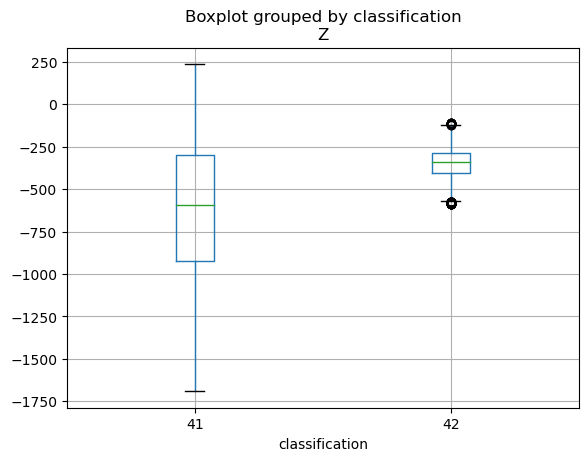

In [22]:
filtered_water_surface_combined_df.boxplot(column='Z', by='classification')


In [23]:
print(filtered_water_surface_combined_df.Z.min())
print(filtered_water_surface_combined_df.Z.mean())
print(filtered_water_surface_combined_df.Z.max())
print(filtered_water_surface_combined_df.intensity.min())
print(filtered_water_surface_combined_df.intensity.mean())
print(filtered_water_surface_combined_df.intensity.max())

-1692
-376.5015969131164
237
1234
59851.39963292676
65530


### Intensity relationship to water surface

<AxesSubplot: title={'center': 'intensity'}, xlabel='classification'>

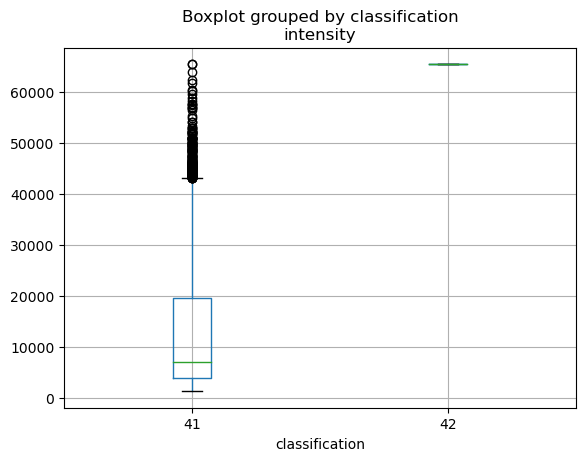

In [24]:
filtered_water_surface_combined_df.boxplot(column='intensity', by='classification')

## Generating Meshes and Vector Normals for the bathymetry as well as water surface:

In [25]:
voxel_size = 1.1

#Entire dataset

filtered_classified_scaled = filtered_classifications["original_dataset"]
filtered_dataset_scaled_pcd = o3d.geometry.PointCloud()
filtered_dataset_scaled_pcd.points = o3d.utility.Vector3dVector(filtered_classified_scaled.xyz)
filtered_dataset_scaled_denoised_voxels = filtered_dataset_scaled_pcd.voxel_down_sample(voxel_size=voxel_size)

#bathymetry dataset only
pcd_bathy = o3d.geometry.PointCloud()
pcd_bathy.points = o3d.utility.Vector3dVector(bathymetry_filtered.xyz)
bathy_denoised_voxels = pcd_bathy.voxel_down_sample(voxel_size=voxel_size)

#combined water surface 41 and 42
water_surface = o3d.geometry.PointCloud()
water_surface.points = o3d.utility.Vector3dVector(filtered_water_surface_combined.xyz)
water_surface_denoised_voxels = water_surface.voxel_down_sample(voxel_size=voxel_size)

###########################
#Normal vector computations
##########################

normal_radius_search = 10
max_nn = 30
#compute normals of the filtered dataset
print("Recompute the normals of the filtered dataset")
filtered_dataset_scaled_pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))
print("Recompute the normals of the voxels for the filtered dataset")
filtered_dataset_scaled_denoised_voxels.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))
#bathymetry normals
print("Recompute the normals of the bathymetry values")
pcd_bathy.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))
print("Recompute the normals of the voxel bathymetry values")
bathy_denoised_voxels.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))
#compute normals
#water surface normals
print("Recompute the normal of the water surface values")
water_surface.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))
print("Recompute the normals of the voxel water surface values")
water_surface_denoised_voxels.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius_search, max_nn=max_nn))

###########################
#Poisson mesh computations
##########################

depth_poisson = 2
print("Creating poisson mesh surface and densities for bathymetry")
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    bathy_mesh, bathy_densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_bathy, depth=depth_poisson)
print("Creating poisson mesh surface and densities for voxelized bathymetry ")
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    voxel_bathy_mesh, voxel_bathy_densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        bathy_denoised_voxels, depth=depth_poisson)
print("Creating poisson mesh surface and densities for water surface")
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    water_surf_mesh, water_surf_densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        water_surface, depth=depth_poisson)
print("Creating poisson mesh surface and densities for voxelized water surface")
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    voxel_water_surf_mesh, voxel_water_surf_densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        water_surface_denoised_voxels, depth=depth_poisson)


Recompute the normals of the filtered dataset
Recompute the normals of the voxels for the filtered dataset
Recompute the normals of the bathymetry values
Recompute the normals of the voxel bathymetry values
Recompute the normal of the water surface values
Recompute the normals of the voxel water surface values
Creating poisson mesh surface and densities for bathymetry
[Open3D DEBUG] Input Points / Samples: 75331 / 22
[Open3D DEBUG] #   Got kernel density: 2.69413e-05 (s), 742.57 (MB) / 742.57 (MB) / 742 (MB)
[Open3D DEBUG] #     Got normal field: 0.000231981 (s), 742.598 (MB) / 742.598 (MB) / 742 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 7.740786e-05 / 5.831212e+00
[Open3D DEBUG] #       Finalized tree: 0.00556016 (s), 742.789 (MB) / 742.789 (MB) / 742 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.00246787 (s), 742.895 (MB) / 742.895 (MB) / 742 (MB)
[Open3D DEBUG] #Set point constraints: 0.00321698 (s), 742.926 (MB) / 742.926 (MB) / 742 (MB)
[Open3D DEBUG] Leaf Nodes / Active 

[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Evaluation.inl (Line 155)
          _getValues
          getValue assumes leaf node
[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Evaluation.inl (Line 155)
          _getValues
          getValue assumes leaf node
[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Evaluation.inl (Line 155)
          _getValues
          getValue assumes leaf node
[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Evaluation.inl (Line 155)
          _getValues
          getValue assumes leaf node
[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Evaluation.inl (Line 155)
          _getValues
          getValue assumes leaf node
[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/

## Visualization of meshes

In [27]:
#Bathymetry and voxel bathymetry
#o3d.visualization.draw_geometries([bathy_mesh,pcd_bathy])
#o3d.visualization.draw_geometries([voxel_bathy_mesh,bathy_denoised_voxels])

#Water surface and voxel water surface
#o3d.visualization.draw_geometries([water_surf_mesh,water_surface])
#o3d.visualization.draw_geometries([voxel_water_surf_mesh,water_surface_denoised_voxels])

# Bathy and water surface and meshes
#o3d.visualization.draw_geometries([bathy_mesh,pcd_bathy,water_surf_mesh,water_surface])

# Voxel bathy and water surface and meshes
#o3d.visualization.draw_geometries([voxel_bathy_mesh,bathy_denoised_voxels,voxel_water_surf_mesh,water_surface_denoised_voxels])

#Entire dataset and meshes
o3d.visualization.draw_geometries([bathy_mesh,water_surf_mesh,filtered_dataset_scaled_pcd])
#Voxel entire dataset and meshes
#o3d.visualization.draw_geometries([voxel_bathy_mesh,voxel_water_surf_mesh,filtered_dataset_scaled_denoised_voxels])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Get a mesh representing density distribution

In [28]:
def get_density_mesh(mesh,densities):
    densities = np.asarray(densities)
    density_colors = plt.get_cmap('plasma')(
        (densities - densities.min()) / (densities.max() - densities.min()))
    density_colors = density_colors[:, :3]
    density_mesh = o3d.geometry.TriangleMesh()
    density_mesh.vertices = mesh.vertices
    density_mesh.triangles = mesh.triangles
    density_mesh.triangle_normals = mesh.triangle_normals
    density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)

    return density_mesh

#bathymetry density mesh
bathy_density_mesh = get_density_mesh(mesh=bathy_mesh,densities=bathy_densities)
voxel_bathy_density_mesh = get_density_mesh(mesh=voxel_bathy_mesh,densities=voxel_bathy_densities)
#o3d.visualization.draw_geometries([voxel_bathy_density_mesh])

#water surface density mesh
water_surf_density_mesh = get_density_mesh(mesh=water_surf_mesh,densities=water_surf_densities)
voxel_water_surf_density_mesh = get_density_mesh(mesh=voxel_water_surf_mesh,densities=voxel_water_surf_densities)
#o3d.visualization.draw_geometries([voxel_water_surf_density_mesh])

#Together
o3d.visualization.draw_geometries([bathy_density_mesh,water_surf_density_mesh,pcd_bathy,water_surface])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Distance calculation to bathymetry mesh

In [29]:
def bathy_surface_compute_distance_and_occupancy(query_points: np.ndarray,bathy_mesh_legacy,signed_flag=True):
    # Define bathy scene
    bathy_scene = o3d.t.geometry.RaycastingScene()
    _ = bathy_scene.add_triangles(bathy_mesh_legacy)
    bathy_surface_occupancy = bathy_scene.compute_occupancy(query_points) 

    if signed_flag == True:
        # Compute the signed distance for all points in the dataset
        bathy_surface_signed_distance = bathy_scene.compute_signed_distance(query_points)
        # Occupancy:1 means the point lies on the mesh
        return bathy_surface_signed_distance, bathy_surface_occupancy
    else:
        # Compute the unsigned distance for all points in the dataset
        bathy_surface_unsigned_distance = bathy_scene.compute_distance(query_points)
        return bathy_surface_unsigned_distance, bathy_surface_occupancy

# Compute_closest_points() computes the closest point on the mesh with respect to query points
def bathy_surface_closest_points(query_points: np.ndarray,bathy_mesh_legacy):
    # Define bathy scene
    bathy_scene = o3d.t.geometry.RaycastingScene()
    _ = bathy_scene.add_triangles(bathy_mesh_legacy)
    bathy_surface_closest_points = bathy_scene.compute_closest_points(query_points) 
    return bathy_surface_closest_points


#the filtered dataset converted to float32
filtered_dataset_float32= np.array(filtered_dataset_scaled_pcd.points)
filtered_dataset_float32 = filtered_dataset_float32.astype(np.float32)
#legacy mesh conversion
bathy_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(bathy_mesh)

#obtain distances
bathy_surface_signed_distance, bathy_surface_occupancy = bathy_surface_compute_distance_and_occupancy(query_points=filtered_dataset_float32,bathy_mesh_legacy=bathy_mesh_legacy,signed_flag=True)
#obtain closest points
bathy_surf_closest_points = bathy_surface_closest_points(query_points=filtered_dataset_float32, bathy_mesh_legacy=bathy_mesh_legacy)





### Distance calculation to water surface mesh for filtered data

In [30]:
def water_surface_compute_distance_and_occupancy(query_points: np.ndarray,water_mesh_legacy,signed_flag=True):

    # Define bathy scene
    water_surface_scene = o3d.t.geometry.RaycastingScene()
    _ = water_surface_scene.add_triangles(water_mesh_legacy)
    # Occupancy:1 means the point lies on the mesh
    water_surface_occupancy = water_surface_scene.compute_occupancy(query_points) 

    if signed_flag == True:
        # Compute the signed distance for all points in the dataset
        water_surface_signed_distance = water_surface_scene.compute_signed_distance(query_points)
        # Occupancy:1 means the point lies on the mesh
        return water_surface_signed_distance, water_surface_occupancy
    else:
        # Compute the unsigned distance for all points in the dataset
        water_surface_unsigned_distance = water_surface_scene.compute_distance(query_points)
        return water_surface_unsigned_distance, water_surface_occupancy

    
# Compute_closest_points() computes the closest point on the mesh with respect to query points
def water_surface_closest_points(query_points: np.ndarray,water_mesh_legacy):
    # Define bathy scene
    water_surface_scene = o3d.t.geometry.RaycastingScene()
    _ = water_surface_scene.add_triangles(water_mesh_legacy)
    water_surface_closest_points = water_surface_scene.compute_closest_points(query_points) 
    return water_surface_closest_points
    


#the filtered dataset converted to float32
filtered_dataset_float32= np.array(filtered_dataset_scaled_pcd.points)
filtered_dataset_float32 = filtered_dataset_float32.astype(np.float32)
#legacy mesh conversion using a mesh generated from denoised data
water_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(water_surf_mesh)

water_surface_signed_distance, water_surface_occupancy = water_surface_compute_distance_and_occupancy(query_points=filtered_dataset_float32,water_mesh_legacy=water_mesh_legacy,signed_flag=True)

water_surf_closest_points = water_surface_closest_points(query_points=filtered_dataset_float32, water_mesh_legacy=water_mesh_legacy)




# Calculating nearest distance to mesh bathymetry or water surface

In [32]:
#dataset
filtered_dataset_float32= np.array(filtered_dataset_scaled_pcd.points)
filtered_dataset_float32 = filtered_dataset_float32.astype(np.float32)

## bathymetry =0 and water surface = 1
bathy_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(bathy_mesh)
water_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(water_surf_mesh)


def bathy_water_compute_signed_distance_and_closest_geometry(query_points: np.ndarray,bathy_mesh_legacy,water_mesh_legacy):
            
    # Define scene
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(bathy_mesh_legacy)] = 'bathymetry'
    mesh_ids[scene.add_triangles(water_mesh_legacy)] = 'water_surface'

    closest_points = scene.compute_closest_points(query_points)
    distance = np.linalg.norm(query_points - closest_points['points'].numpy(),
                              axis=-1)
    return distance, closest_points['geometry_ids'].numpy()



distance_to_either,closest_mesh =bathy_water_compute_signed_distance_and_closest_geometry(query_points=filtered_dataset_float32,bathy_mesh_legacy=bathy_mesh_legacy,water_mesh_legacy=water_mesh_legacy)

# Appending results to filtered dataset's dataframe.

All of the meshes were created using data from the filtered_dataset (df_filtered).

In [33]:
#df_filtered
filtered_classified_scaled = filtered_classifications["original_dataset"]

filtered_dataset_scaled_pcd = o3d.geometry.PointCloud()
filtered_dataset_scaled_pcd.points = o3d.utility.Vector3dVector(filtered_classified_scaled.xyz)

filtered_dataset_float32= np.array(filtered_dataset_scaled_pcd.points)
filtered_dataset_float32 = filtered_dataset_float32.astype(np.float32)


## bathymetry =0 and water surface = 1
bathy_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(bathy_mesh)
water_mesh_legacy = o3d.t.geometry.TriangleMesh.from_legacy(water_surf_mesh)


#Calculate distances from all of the cleaned points to the bathymetry surface

####bathymetry
#obtain distances
og_bathy_surface_signed_distance, og_bathy_surface_occupancy = bathy_surface_compute_distance_and_occupancy(query_points=filtered_dataset_float32,bathy_mesh_legacy=bathy_mesh_legacy,signed_flag=True)
#obtain closest points
og_bathy_surf_closest_points = bathy_surface_closest_points(query_points=filtered_dataset_float32, bathy_mesh_legacy=bathy_mesh_legacy)


##### water surface distances
og_water_surface_signed_distance, og_water_surface_occupancy = water_surface_compute_distance_and_occupancy(query_points=filtered_dataset_float32,water_mesh_legacy=water_mesh_legacy,signed_flag=True)

og_water_surf_closest_points = water_surface_closest_points(query_points=filtered_dataset_float32, water_mesh_legacy=water_mesh_legacy)

#both
distance_to_either,closest_mesh = bathy_water_compute_signed_distance_and_closest_geometry(query_points=filtered_dataset_float32,bathy_mesh_legacy=bathy_mesh_legacy,water_mesh_legacy=water_mesh_legacy)


In [34]:
filtered_classified_scaled_df = convert_laspy_pandas(filtered_classified_scaled)

In [35]:
filtered_classified_scaled_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
0,290986456,-186841756,-346,290986.456,4813158.244,-0.346,6084,9,1,1,0,0,0,0,0,1,1,-2105,2610,135244.344606
1,290986347,-186841735,-327,290986.347,4813158.265,-0.327,1679,9,1,1,0,0,0,0,0,1,1,-2102,2610,135244.344608
2,290986026,-186841690,-332,290986.026,4813158.310,-0.332,4830,9,1,1,0,0,0,0,0,1,1,-2095,2610,135244.344614
3,290985919,-186841677,-339,290985.919,4813158.323,-0.339,10843,9,1,1,0,0,0,0,0,1,1,-2093,2610,135244.344616
4,290987973,-186842938,-351,290987.973,4813157.062,-0.351,2822,9,1,1,0,0,0,0,0,1,1,-2148,2610,135244.358790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312092,291036269,-186921507,-279,291036.269,4813078.493,-0.279,65530,42,0,1,0,0,0,0,0,0,4,2721,2812,135838.509012
312093,291036953,-186921408,-274,291036.953,4813078.592,-0.274,65530,42,0,2,0,0,0,0,0,0,4,2710,2812,135838.509027
312094,291036120,-186922065,-280,291036.120,4813077.935,-0.280,65530,42,0,2,0,0,0,0,0,0,4,2718,2812,135838.518345
312095,291036078,-186921990,-627,291036.078,4813078.010,-0.627,3529,0,1,2,0,0,0,0,0,0,4,2718,2812,135838.518345


In [63]:
filtered_classified_scaled_df["signed_dist_to_bathy_mesh"] = np.array(og_bathy_surface_signed_distance.numpy())
filtered_classified_scaled_df["bathy_mesh_occupancy"] = np.array(og_bathy_surface_occupancy.numpy())
filtered_classified_scaled_df["signed_dist_to_water_mesh"] = np.array(og_water_surface_signed_distance.numpy())
filtered_classified_scaled_df["water_mesh_occupancy"] = np.array(og_water_surface_occupancy.numpy())
filtered_classified_scaled_df["closest_mesh"] = np.array(closest_mesh)

In [64]:
filtered_classified_scaled_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,...,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time,signed_dist_to_bathy_mesh,bathy_mesh_occupancy,signed_dist_to_water_mesh,water_mesh_occupancy,closest_mesh
0,290986456,-186841756,-346,290986.456,4813158.244,-0.346,6084,9,1,1,...,1,1,-2105,2610,135244.344606,5.778664,0.0,0.121187,0.0,1
1,290986347,-186841735,-327,290986.347,4813158.265,-0.327,1679,9,1,1,...,1,1,-2102,2610,135244.344608,5.789657,0.0,0.144040,0.0,1
2,290986026,-186841690,-332,290986.026,4813158.310,-0.332,4830,9,1,1,...,1,1,-2095,2610,135244.344614,5.771144,0.0,0.140366,0.0,1
3,290985919,-186841677,-339,290985.919,4813158.323,-0.339,10843,9,1,1,...,1,1,-2093,2610,135244.344616,5.758752,0.0,0.133897,0.0,1
4,290987973,-186842938,-351,290987.973,4813157.062,-0.351,2822,9,1,1,...,1,1,-2148,2610,135244.358790,5.843693,0.0,0.103174,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312092,291036269,-186921507,-279,291036.269,4813078.493,-0.279,65530,42,0,1,...,0,4,2721,2812,135838.509012,8.440096,0.0,0.217689,0.0,1
312093,291036953,-186921408,-274,291036.953,4813078.592,-0.274,65530,42,0,2,...,0,4,2710,2812,135838.509027,8.466109,0.0,0.228344,0.0,1
312094,291036120,-186922065,-280,291036.120,4813077.935,-0.280,65530,42,0,2,...,0,4,2718,2812,135838.518345,8.437331,0.0,0.217986,0.0,1
312095,291036078,-186921990,-627,291036.078,4813078.010,-0.627,3529,0,1,2,...,0,4,2718,2812,135838.518345,8.088868,0.0,-0.131779,1.0,1


In [67]:
#recall
def create_laspy_from_dataframe_augmented(input_las,combined_df):
    #classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

    #Create a header for the new .Las file
    # Header class properties (https://laspy.readthedocs.io/en/latest/api/laspy.header.html)
    header = laspy.LasHeader(point_format=input_las.header.point_format, version=input_las.header.version)
    header.scales = np.array([0.001, 0.001, 0.001])
    header.x_offset=input_las.header.offsets[0]
    header.y_offset=input_las.header.offsets[1]
    header.z_offset=input_las.header.offsets[2]

    classified_points = laspy.LasData(header)

    crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
    #Apply the add_crs function to add a crs to our header.
    classified_points.header.add_crs(crs)
    #Select the offset from the input las data.

    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]
    classified_points.return_number = combined_df["return_number"]
    classified_points.number_of_returns = combined_df["number_of_returns"]
    classified_points.synthetic = combined_df["synthetic"]
    classified_points.key_point = combined_df["key_point"]
    classified_points.withheld = combined_df["withheld"]
    classified_points.scanner_channel = combined_df["scanner_channel"]
    classified_points.scan_direction_flag = combined_df["scan_direction_flag"]
    classified_points.user_data = combined_df["user_data"]
    classified_points.withheld = combined_df["withheld"]
    classified_points.scan_angle = combined_df["scan_angle"]
    classified_points.point_source_id = combined_df["point_source_id"]
    classified_points.gps_time = combined_df["gps_time"]


    classified_points.header.offsets = input_las.header.offsets

    
    return classified_points

In [68]:
df_aug = create_laspy_from_dataframe_augmented(input_las =filtered_classified_scaled ,combined_df=filtered_classified_scaled_df)

In [71]:
df_aug.intensity

array([ 6084,  1679,  4830, ..., 65530,  3529,  2180], dtype=uint16)

In [ ]:
df_filtered 

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
0,290986456,-186841756,-346,290986.456,4813158.244,-0.346,6084,9,1,1,0,0,0,0,0,1,1,-2105,2610,135244.344606
1,290986347,-186841735,-327,290986.347,4813158.265,-0.327,1679,9,1,1,0,0,0,0,0,1,1,-2102,2610,135244.344608
2,290986026,-186841690,-332,290986.026,4813158.310,-0.332,4830,9,1,1,0,0,0,0,0,1,1,-2095,2610,135244.344614
3,290985919,-186841677,-339,290985.919,4813158.323,-0.339,10843,9,1,1,0,0,0,0,0,1,1,-2093,2610,135244.344616
4,290987973,-186842938,-351,290987.973,4813157.062,-0.351,2822,9,1,1,0,0,0,0,0,1,1,-2148,2610,135244.358790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312092,291036269,-186921507,-279,291036.269,4813078.493,-0.279,65530,42,0,1,0,0,0,0,0,0,4,2721,2812,135838.509012
312093,291036953,-186921408,-274,291036.953,4813078.592,-0.274,65530,42,0,2,0,0,0,0,0,0,4,2710,2812,135838.509027
312094,291036120,-186922065,-280,291036.120,4813077.935,-0.280,65530,42,0,2,0,0,0,0,0,0,4,2718,2812,135838.518345
312095,291036078,-186921990,-627,291036.078,4813078.010,-0.627,3529,0,1,2,0,0,0,0,0,0,4,2718,2812,135838.518345


## Converting coordinates to lat/long

In [ ]:
from pyproj import transformer
# Define transformation parameters from CRS 2960 to WGS84
transformer = Transformer.from_crs(2960, 'EPSG:4326')
# Transform x, y, z coordinates to lat/long
lat, long, _ = transformer.transform(filtered_water_surface_combined.x, filtered_water_surface_combined.y, filtered_water_surface_combined.z)


filtered_water_surface_combined_df["lat"], filtered_water_surface_combined_df["long"],_  = transformer.transform(filtered_water_surface_combined.x, filtered_water_surface_combined.y, filtered_water_surface_combined.Z)

In [ ]:
filtered_water_surface_combined_df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,...,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time,lat,long
283,290990604,-186842791,-671,290990.604,4813157.209,-0.671,2471,41,1,4,...,0,0,0,1,2,-2197,2610,135244.360759,43.442159,-71.582819
310,290992488,-186844162,-381,290992.488,4813155.838,-0.381,30608,41,1,2,...,0,0,0,1,2,-2250,2610,135244.379323,43.442147,-71.582795
312,290991346,-186844085,-555,290991.346,4813155.915,-0.555,2481,41,1,2,...,0,0,0,1,2,-2226,2610,135244.379351,43.442148,-71.582809
313,290990175,-186843962,-549,290990.175,4813156.038,-0.549,9932,41,1,2,...,0,0,0,1,2,-2202,2610,135244.379380,43.442148,-71.582824
316,290987794,-186843746,-824,290987.794,4813156.254,-0.824,2529,41,2,5,...,0,0,0,1,2,-2151,2610,135244.379439,43.442150,-71.582853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158764,291023560,-186895226,-359,291023.560,4813104.774,-0.359,65530,42,0,1,...,0,0,0,0,4,3185,2812,135838.014091,43.441697,-71.582392
158765,291024768,-186894785,-357,291024.768,4813105.215,-0.357,65530,42,0,2,...,0,0,0,0,4,3169,2812,135838.014120,43.441701,-71.582377
159499,291000426,-186920551,-359,291000.426,4813079.449,-0.359,65530,42,0,1,...,0,0,0,0,4,3318,2812,135838.256111,43.441462,-71.582668
159525,291000692,-186920865,-362,291000.692,4813079.135,-0.362,65530,42,0,1,...,0,0,0,0,4,3311,2812,135838.265454,43.441460,-71.582664


In [ ]:
from pyproj import transformer
# Define transformation parameters from CRS 2960 to WGS84
transformer = Transformer.from_crs(2960, 'EPSG:4326')
# Transform x, y, z coordinates to lat/long
lat, long, _ = transformer.transform(filtered_las.x, filtered_las.y, filtered_las.z)


df_filtered["lat"], df_filtered["long"],_  = transformer.transform(filtered_las.x, filtered_las.y, filtered_las.Z)


In [ ]:
np.array(filtered_las.x).mean()
np.array(filtered_las.y).mean()

4813115.849317384

distance between two points

In [ ]:
filtered_las.y[0]

4813155.382

In [ ]:
lat1, lon1, _ = transformer.transform(np.array(filtered_las.x).mean(), np.array(filtered_las.y).mean(),np.array(filtered_las.z).mean())


In [ ]:
lat2, lon2, _ = transformer.transform(np.array(filtered_las.x).mean()+1000, np.array(filtered_las.y).mean(),np.array(filtered_las.z).mean())


In [ ]:
from math import sin, cos, sqrt, atan2, radians

def distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    # convert degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # calculate the difference between the latitudes and longitudes
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # apply the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # calculate the distance
    distance = R * c

    return distance


In [ ]:


# calculate the distance between the two points
distance = distance(lat1, lon1, lat2, lon2)

print(distance)


0.9974811167059876


# Testing:

# Creating plane geometries

Use combined water surface.
Create bounding box.
Voxelize
Fit plane to voxels

# broke this lol


In [ ]:
pcd_filtered_water_surface_combined = o3d.geometry.PointCloud()
pcd_filtered_water_surface_combined.points = o3d.utility.Vector3dVector(filtered_water_surface_combined.xyz)
abb = pcd_filtered_water_surface_combined.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd_filtered_water_surface_combined.get_oriented_bounding_box()
obb.color = (0,0,0)

filtered_water_surface_combined_denoised_voxels = pcd_filtered_water_surface_combined.voxel_down_sample(voxel_size=1.1)

plane_filtered_water_surface_combined_denoised, inliers_filtered_water_surface_combined_denoised = pcd_filtered_water_surface_combined.segment_plane(distance_threshold=1.01, ransac_n=10, num_iterations=1000)
voxels_plane_model_bathy, voxels_inliers_bathy = filtered_water_surface_combined_denoised_voxels.segment_plane(distance_threshold=1.01, ransac_n=10, num_iterations=1000)

[a, b, c, d] = plane_filtered_water_surface_combined_denoised
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

[a_voxel, b_voxel, c_voxel, d_voxel] = voxels_plane_model_bathy
print(f"Plane equation: {a_voxel:.2f}x + {b_voxel:.2f}y + {c_voxel:.2f}z + {d_voxel:.2f} = 0")

inlier_cloud = filtered_water_surface_combined.select_by_index(inliers_filtered_water_surface_combined_denoised)
inlier_cloud.paint_uniform_color([0.0, 0, 0])
outlier_cloud = filtered_water_surface_combined.select_by_index(inliers_filtered_water_surface_combined_denoised, invert=True)
o3d.visualization.draw_geometries([inlier_cloud,abb,obb])



Plane equation: -0.00x + -0.00y + 1.00z + 1642.00 = 0
Plane equation: -0.00x + -0.00y + 1.00z + 10596.16 = 0


AttributeError: LasData object has no attribute 'select_by_index'

In [ ]:

water_surface_plane_model, water_surface_inliers = water_surface.segment_plane(distance_threshold=1.01, ransac_n=10, num_iterations=1000)
water_surface_voxels_plane_model, water_surface_voxels_inliers = denoised_voxels.segment_plane(distance_threshold=1.01, ransac_n=10, num_iterations=1000)


